In [1]:
#!pip install umap-learn


In [2]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.manifold import Isomap, TSNE
import umap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
from umap import UMAP
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


c:\Users\timan\anaconda3\envs\PoDS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


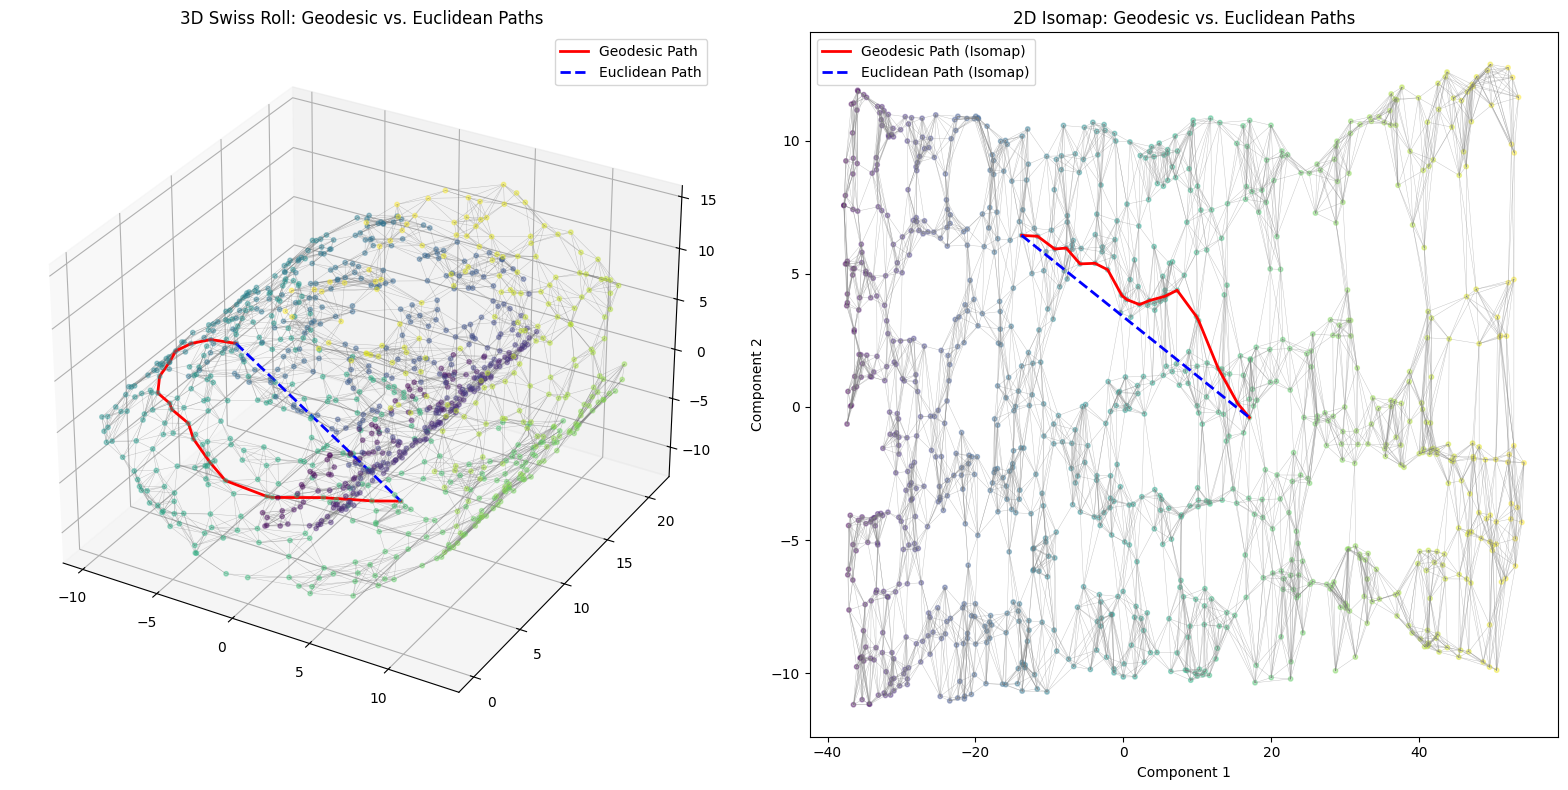

3D Euclidean distance: 20.66
3D Geodesic distance: 31.48
2D Euclidean distance (Isomap): 31.54


In [3]:
# the code for this cell is generated by chatgbt

# Generate Swiss Roll data
points, color = make_swiss_roll(n_samples=1000, noise=0.1, random_state=42)
p1, p2 = 0, 500  # Points to compare

# Compute geodesic path (k-NN graph)
nbrs = NearestNeighbors(n_neighbors=10).fit(points)
_, indices = nbrs.kneighbors(points)
G = nx.Graph()
for i in range(points.shape[0]):
    for j in indices[i]: # iterate over all the neighbour in vertex i
        if i != j: # make sure no loop
            G.add_edge(i, j, weight=np.linalg.norm(points[i] - points[j]))
# get the vertices of the geodesic distance(shortest path)
path = nx.shortest_path(G, source=p1, target=p2, weight='weight')

# apply Isomap
iso = Isomap(n_neighbors=10, n_components=2)
points_iso = iso.fit_transform(points) # transform the original data points to the lower dimension

# Path coordinates
path_3d = points[path]  # 3D geodesic path
path_iso = points_iso[path]  # 2D geodesic path
euclidean_3d = np.array([points[p1], points[p2]])  # 3D straight line
euclidean_iso = np.array([points_iso[p1], points_iso[p2]])  # 2D straight line

# Plotting
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(points[:, 0], points[:, 1], points[:, 2], c=color, cmap=plt.cm.viridis, s=10, alpha=0.4)

# show the knn graph edge
for i in range(points.shape[0]):
    for j in indices[i]:
        if i < j:
            ax1.plot([points[i,0], points[j,0]], [points[i,1], points[j,1]], [points[i,2], points[j,2]], 
                     color='gray', alpha=0.5, lw=0.3)

# Geodesic vs. Euclidean paths in the 3d 10-nn graph
ax1.plot(path_3d[:,0], path_3d[:,1], path_3d[:,2], 
         color='red', lw=2, label='Geodesic Path')
ax1.plot(euclidean_3d[:,0], euclidean_3d[:,1], euclidean_3d[:,2], 
         color='blue', linestyle='--', lw=2, label='Euclidean Path')
ax1.set_title("3D Swiss Roll: Geodesic vs. Euclidean Paths")
ax1.legend()


ax2 = fig.add_subplot(122)
ax2.scatter(points_iso[:,0], points_iso[:,1], c=color, cmap=plt.cm.viridis, s=10, alpha=0.4)

# Plot k-NN graph edges (2D)
knn_graph_2d = kneighbors_graph(points_iso, n_neighbors=10, mode='connectivity')
G_2d = nx.from_scipy_sparse_array(knn_graph_2d)
for i, j in G_2d.edges():
    ax2.plot([points_iso[i,0], points_iso[j,0]], [points_iso[i,1], points_iso[j,1]], 
             color='gray', alpha=0.5, lw=0.3)

# Geodesic vs. Euclidean paths
ax2.plot(path_iso[:,0], path_iso[:,1], 
         color='red', lw=2, label='Geodesic Path (Isomap)')
ax2.plot(euclidean_iso[:,0], euclidean_iso[:,1], 
         color='blue', linestyle='--', lw=2, label='Euclidean Path (Isomap)')
ax2.set_title("2D Isomap: Geodesic vs. Euclidean Paths")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")
ax2.legend()

plt.tight_layout()
plt.show()
print(f"3D Euclidean distance: {np.linalg.norm(points[p1] - points[p2]):.2f}")
print(f"3D Geodesic distance: {sum(np.linalg.norm(path_3d[i+1] - path_3d[i]) for i in range(len(path_3d)-1)):.2f}")
print(f"2D Euclidean distance (Isomap): {np.linalg.norm(points_iso[p1] - points_iso[p2]):.2f}")

# Fashion MNIST

PCA:0.0740 seconds
Isomap:1.4246 seconds
t-SNE:5.4410 seconds


c:\Users\timan\anaconda3\envs\PoDS\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP:11.9200 seconds


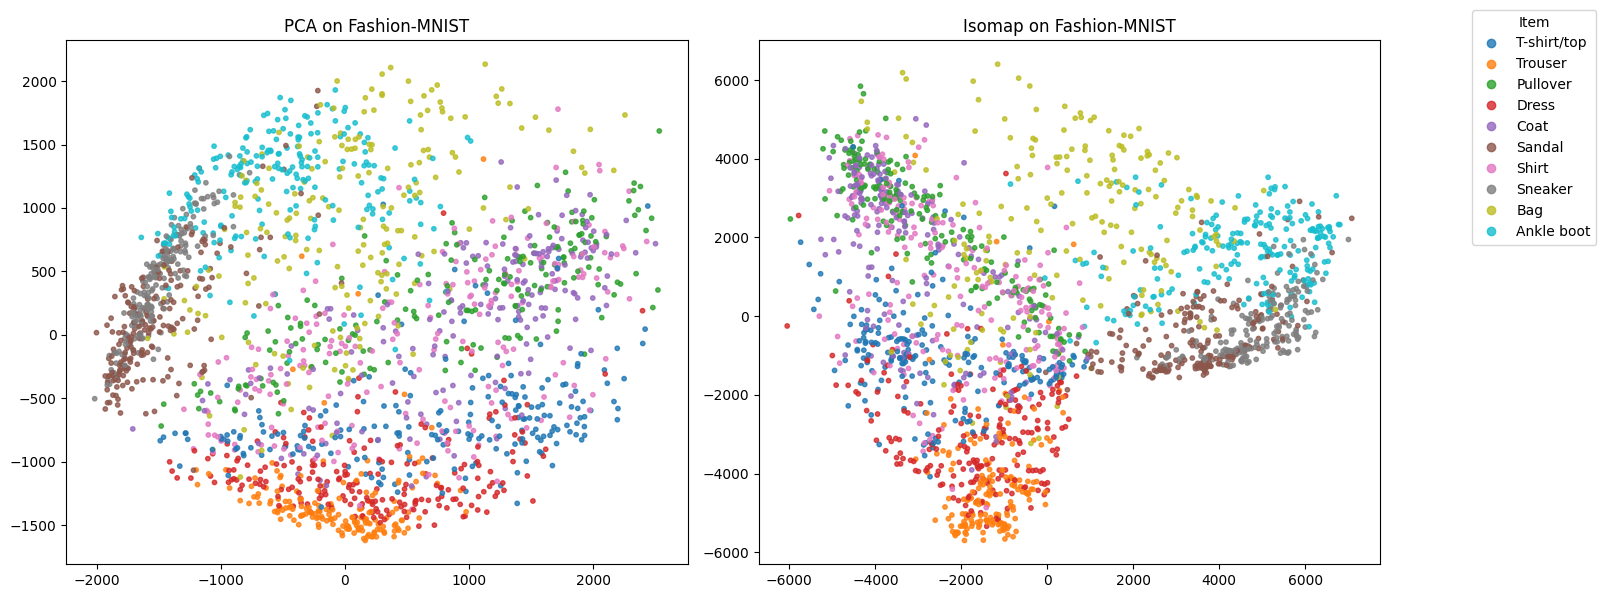

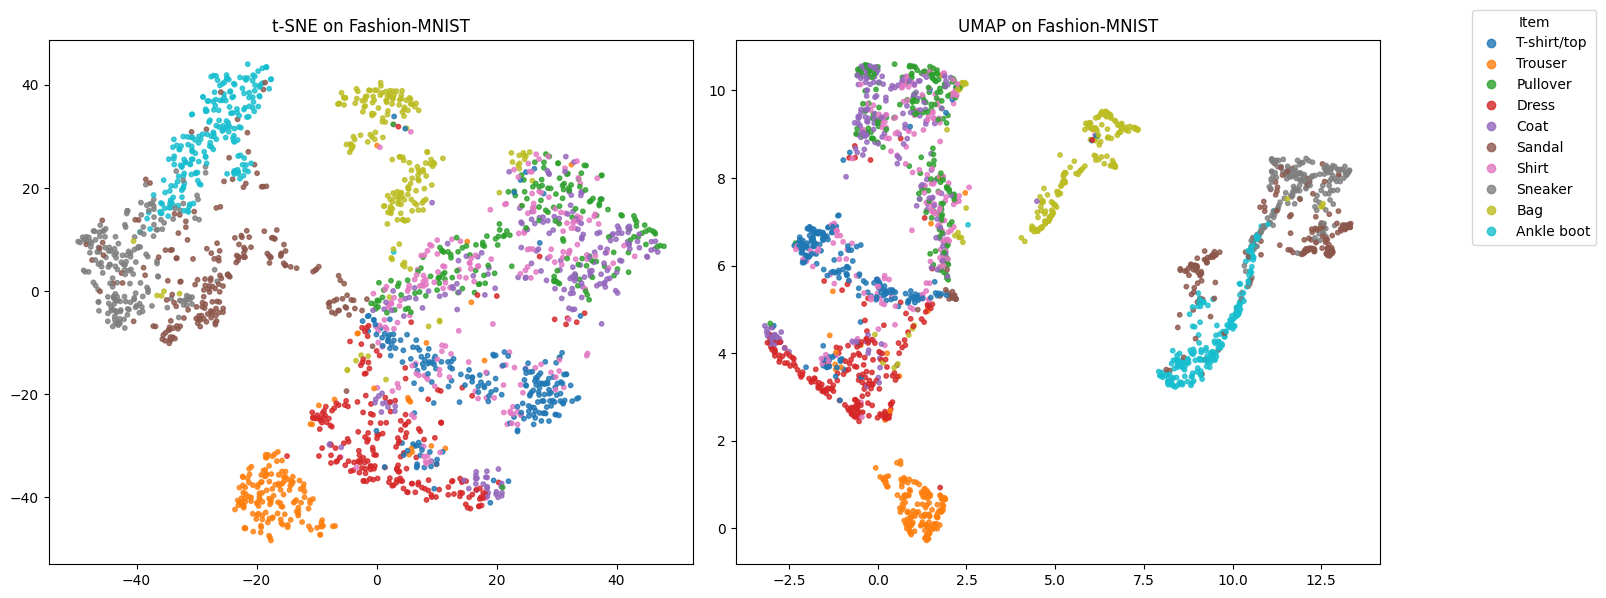

In [4]:


# Label mapping for Fashion MNIST
fashion_labels = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
}

fmnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
X = fmnist.data
y = fmnist.target.astype(int)

# use 2000 samples to reduce the computational cost
n_samples = 2000
np.random.seed(42)
indices = np.random.choice(len(X), n_samples, replace=False)
X = X[indices]
y = y[indices]

# PCA
start=time.time()
X_pca=PCA(n_components=2,random_state=42).fit_transform(X)
print(f"PCA:{time.time() - start:.4f} seconds")

# 2.Isomap
start=time.time()
X_iso = Isomap(n_components=2,n_neighbors=15).fit_transform(X)
print(f"Isomap:{time.time() - start:.4f} seconds")

# 3.t-SNE
start=time.time()
X_tsne = TSNE(n_components=2, init="pca", random_state=42, perplexity=30).fit_transform(X)
print(f"t-SNE:{time.time() - start:.4f} seconds")

# 4.UMAP
start=time.time()
X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
print(f"UMAP:{time.time() - start:.4f} seconds")


# the code below to plot the graph is generated by AI
# 5. Plotting function with label names
fig1, axs1 = plt.subplots(1, 2, figsize=(14, 6))

sc1 = axs1[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=10, alpha=0.8)
axs1[0].set_title("PCA on Fashion-MNIST")

sc2 = axs1[1].scatter(X_iso[:, 0], X_iso[:, 1], c=y, cmap='tab10', s=10, alpha=0.8)
axs1[1].set_title("Isomap on Fashion-MNIST")

# Shared legend
handles, _ = sc1.legend_elements()
labels = [fashion_labels[i] for i in np.unique(y)]
fig1.legend(handles, labels, title="Item", bbox_to_anchor=(1.05, 1), loc='upper left')
fig1.tight_layout()
plt.show()

# 4. Plot t-SNE & UMAP
fig2, axs2 = plt.subplots(1, 2, figsize=(14, 6))

sc3 = axs2[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', s=10, alpha=0.8)
axs2[0].set_title("t-SNE on Fashion-MNIST")

sc4 = axs2[1].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='tab10', s=10, alpha=0.8)
axs2[1].set_title("UMAP on Fashion-MNIST")

# Shared legend
handles, _ = sc3.legend_elements()
fig2.legend(handles, labels, title="Item", bbox_to_anchor=(1.05, 1), loc='upper left')
fig2.tight_layout()
plt.show()


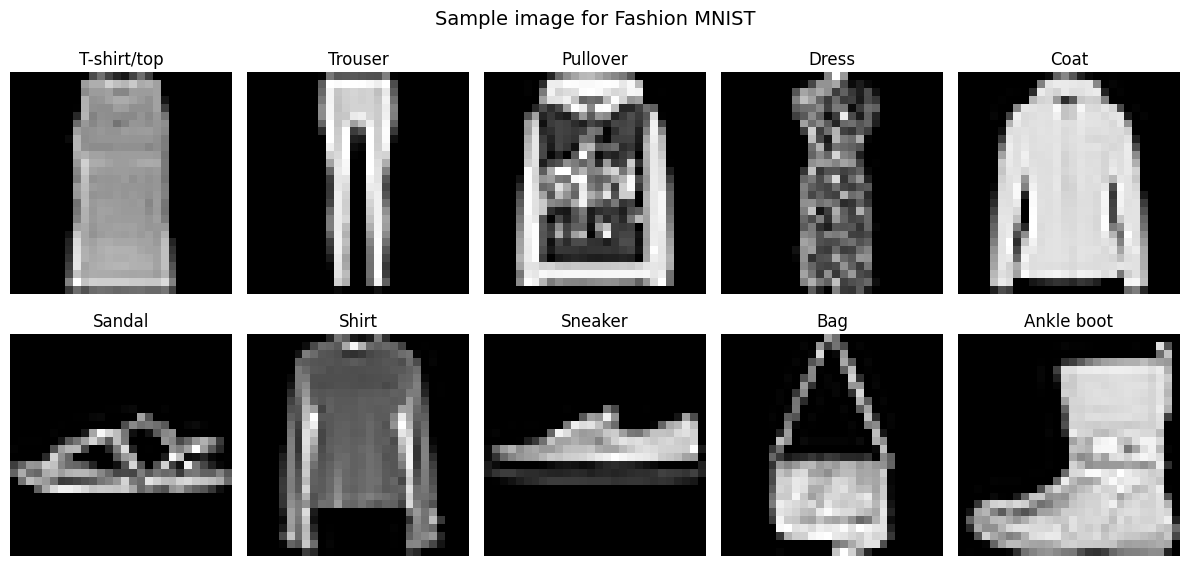

In [5]:
# this is generated by chatgbt
# 7. Plot one image per label to understand the dataset
def plot_sample_images_per_label(X, y, labels_dict):
    plt.figure(figsize=(12, 6))
    shown_labels = set()
    label_indices = {}

    # Find one index per label
    for idx, label in enumerate(y):
        if label not in shown_labels:
            label_indices[label] = idx
            shown_labels.add(label)
        if len(shown_labels) == len(labels_dict):
            break

    # Plot the samples
    for i, label in enumerate(sorted(label_indices.keys())):
        idx = label_indices[label]
        img = X[idx].reshape(28, 28)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(labels_dict[label])
        plt.axis('off')

    plt.suptitle("Sample image for Fashion MNIST", fontsize=14)
    plt.tight_layout()
    plt.show()

# Call the function
plot_sample_images_per_label(X, y, fashion_labels)


# har dataset

In [6]:
# this is copied from the principle of AI (coursework)
# load the dataset

PATH = "C:/Users/timan/OneDrive/Desktop/intro to AI/UCI HAR Dataset/"
features_path = PATH + "features.txt"
activity_labels_path = PATH + "activity_labels.txt"
X_train_path = PATH + "train/X_train.txt"
y_train_path = PATH + "train/y_train.txt"
X_test_path = PATH + "test/X_test.txt"
y_test_path = PATH + "test/y_test.txt"

# Load feature names
features_df = pd.read_csv(features_path, sep="\\s+", header=None, names=["idx", "feature"])
feature_names = features_df["feature"].tolist()

seen = {}
unique_feature_names = []
for x in feature_names:
    if x not in seen:
        seen[x] = 0
        unique_feature_names.append(x)
    else:
        seen[x] += 1

        unique_feature_names.append(f"{x}_{seen[x]}")


# Load activity labels (mapping IDs 1-6 to string names)
activity_labels_df = pd.read_csv(activity_labels_path, sep="\\s+", header=None, names=["id", "activity"])
activity_map = dict(zip(activity_labels_df.id, activity_labels_df.activity))

# Load train/test sets
X_train = pd.read_csv(X_train_path, sep="\\s+", header=None, names=unique_feature_names)
Y_train = pd.read_csv(y_train_path, sep="\\s+", header=None, names=["Activity"])
X_test = pd.read_csv(X_test_path, sep="\\s+", header=None, names=unique_feature_names)
Y_test = pd.read_csv(y_test_path, sep="\\s+", header=None, names=["Activity"])

# Map the activity IDs to their names
Y_train["Activity"] = Y_train["Activity"].map(activity_map)
Y_test["Activity"] = Y_test["Activity"].map(activity_map)

# Combine train and test
X_all = pd.concat([X_train, X_test], ignore_index=True)
Y_all = pd.concat([Y_train, Y_test], ignore_index=True)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

PCA:0.1010 seconds
ISOMAP:37.6369 seconds


c:\Users\timan\anaconda3\envs\PoDS\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP:15.8124 seconds
T-SNE:38.9556 seconds


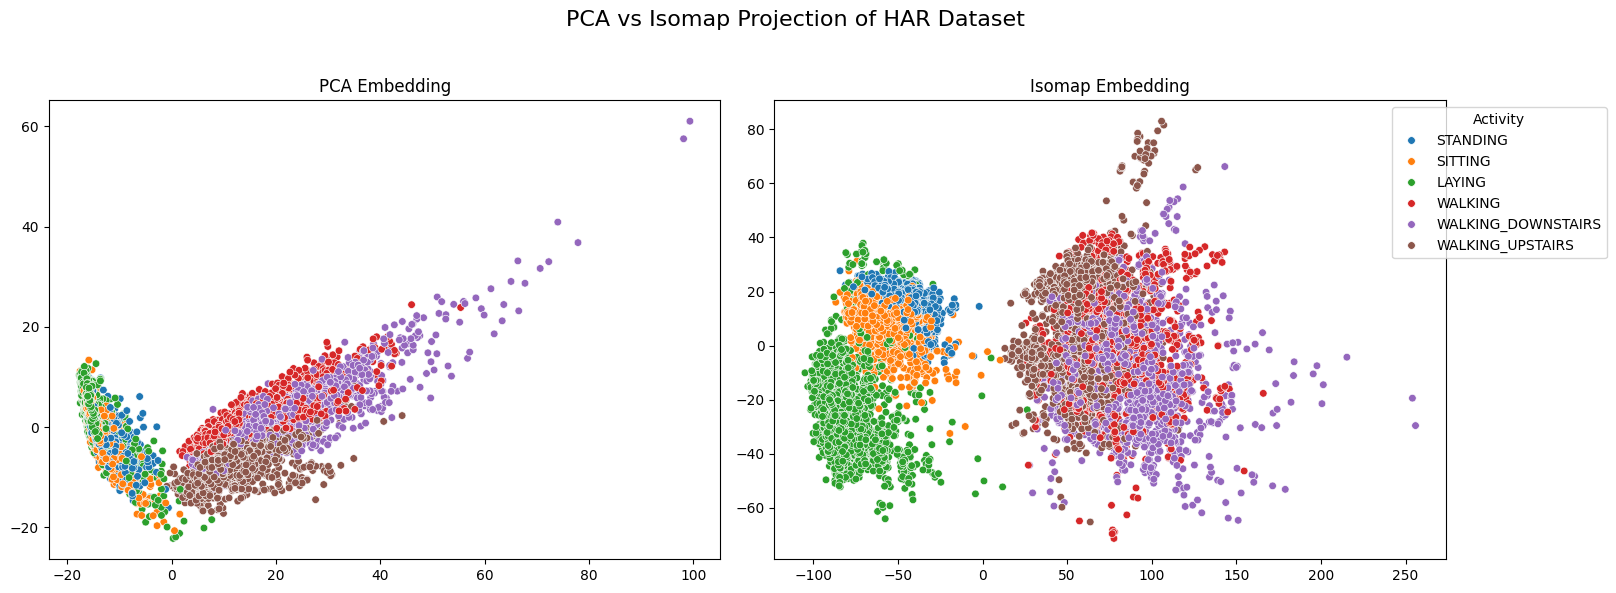

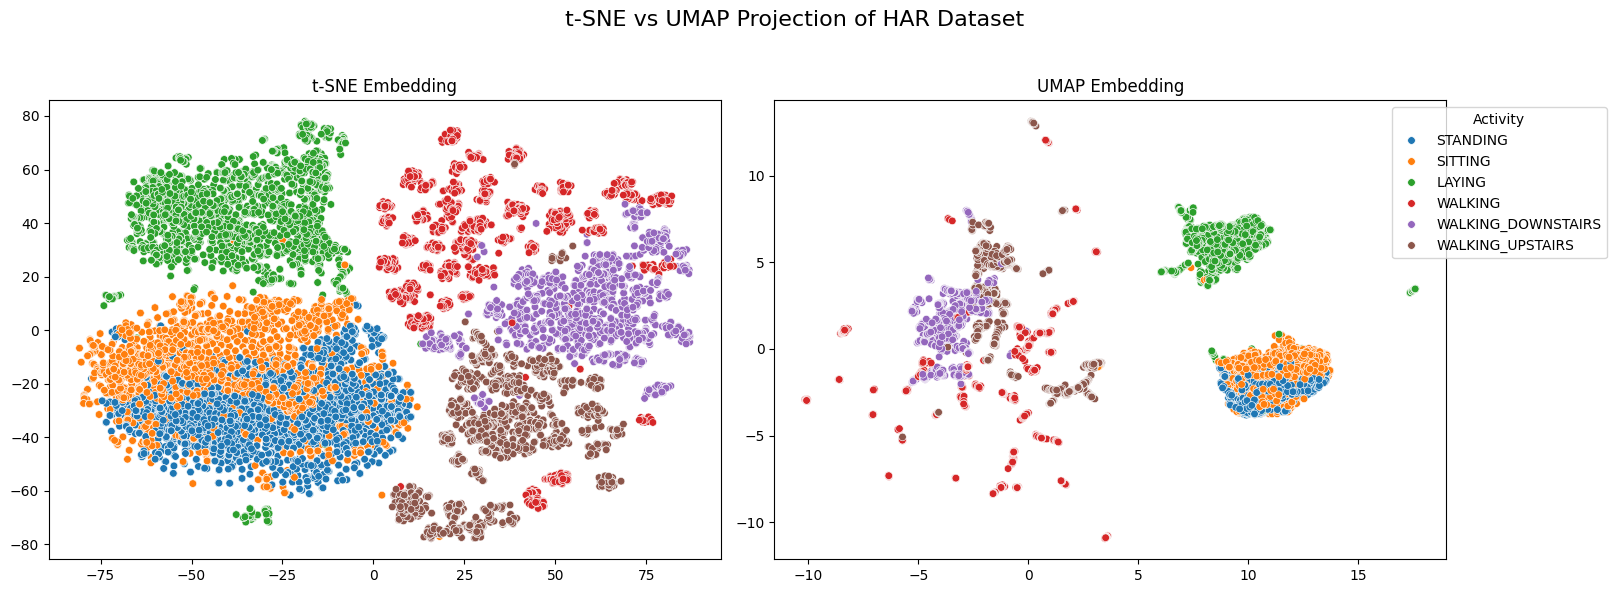

In [7]:
# PCA
start=time.time()
X_pca=PCA(n_components=2,random_state=42).fit_transform(X_scaled)
print(f"PCA:{time.time() - start:.4f} seconds")

# Isomap
start=time.time()
isomap = Isomap(n_neighbors=10, n_components=2)
X_isomap = isomap.fit_transform(X_scaled)
print(f"ISOMAP:{time.time() - start:.4f} seconds")

# UMAP
start=time.time()
umap = UMAP(n_neighbors=10, n_components=2, random_state=42)
X_umap = umap.fit_transform(X_scaled)
print(f"UMAP:{time.time() - start:.4f} seconds")

# T-SNE
start=time.time()
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
print(f"T-SNE:{time.time() - start:.4f} seconds")


# the code below to plot the graph is generated by AI
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))
fig1.suptitle("PCA vs Isomap Projection of HAR Dataset", fontsize=16)

# PCA
sns.scatterplot(ax=axes1[0],
                x=X_pca[:, 0], y=X_pca[:, 1],
                hue=Y_all["Activity"], palette="tab10", s=30, legend=False)
axes1[0].set_title("PCA Embedding")

# Isomap
sns.scatterplot(ax=axes1[1],
                x=X_isomap[:, 0], y=X_isomap[:, 1],
                hue=Y_all["Activity"], palette="tab10", s=30)
axes1[1].set_title("Isomap Embedding")
axes1[1].legend(loc='upper right', bbox_to_anchor=(1.25, 1.0), title='Activity')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# --- Figure 2: t-SNE and UMAP ---

fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
fig2.suptitle("t-SNE vs UMAP Projection of HAR Dataset", fontsize=16)

# t-SNE
sns.scatterplot(ax=axes2[0],
                x=X_tsne[:, 0], y=X_tsne[:, 1],
                hue=Y_all["Activity"], palette="tab10", s=30, legend=False)
axes2[0].set_title("t-SNE Embedding")

# UMAP
sns.scatterplot(ax=axes2[1],
                x=X_umap[:, 0], y=X_umap[:, 1],
                hue=Y_all["Activity"], palette="tab10", s=30)
axes2[1].set_title("UMAP Embedding")
axes2[1].legend(loc='upper right', bbox_to_anchor=(1.25, 1.0), title='Activity')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [8]:
X_all.head(1)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.0304,-0.464761,-0.018446,-0.841247,0.179941,-0.058627


# measurement for local preservation 

In [9]:
def knn_score(X_embedded, y_labels):
    knn = KNeighborsClassifier(n_neighbors=5)
    scores = cross_val_score(knn, X_embedded, y_labels, cv=5)
    return scores.mean()

print(f"PCA k-NN accuracy: {knn_score(X_pca, Y_all['Activity']):.4f}")
print(f"Isomap k-NN accuracy: {knn_score(X_isomap, Y_all['Activity']):.4f}")
print(f"UMAP k-NN accuracy: {knn_score(X_umap, Y_all['Activity']):.4f}")
print(f"t-SNE k-NN accuracy: {knn_score(X_tsne, Y_all['Activity']):.4f}")
from sklearn.manifold import trustworthiness

print(f"PCA Trustworthiness: {trustworthiness(X_scaled, X_pca):.4f}")
print(f"Isomap Trustworthiness: {trustworthiness(X_scaled, X_isomap):.4f}")
print(f"UMAP Trustworthiness: {trustworthiness(X_scaled, X_umap):.4f}")
print(f"t-SNE Trustworthiness: {trustworthiness(X_scaled, X_tsne):.4f}")
import pandas as pd
results = {
    "Method": ["PCA", "Isomap", "UMAP", "t-SNE"],
    "k-NN Accuracy": [
        knn_score(X_pca, Y_all["Activity"]),
        knn_score(X_isomap, Y_all["Activity"]),
        knn_score(X_umap, Y_all["Activity"]),
        knn_score(X_tsne, Y_all["Activity"])
    ],
    "Trustworthiness": [
        trustworthiness(X_scaled, X_pca),
        trustworthiness(X_scaled, X_isomap),
        trustworthiness(X_scaled, X_umap),
        trustworthiness(X_scaled, X_tsne)
    ]
}

df_results = pd.DataFrame(results)
print(df_results)

PCA k-NN accuracy: 0.5196
Isomap k-NN accuracy: 0.6731
UMAP k-NN accuracy: 0.8605
t-SNE k-NN accuracy: 0.9007
PCA Trustworthiness: 0.8805
Isomap Trustworthiness: 0.9000
UMAP Trustworthiness: 0.9621
t-SNE Trustworthiness: 0.9887
   Method  k-NN Accuracy  Trustworthiness
0     PCA       0.519565         0.880494
1  Isomap       0.673076         0.900035
2    UMAP       0.860472         0.962134
3   t-SNE       0.900671         0.988659


In [10]:
#pip install zadu

# Measurement for Global preservation(Kruskal’s Stress and Spearman’s Rank Correlation Coefficient)
the code below is copied from the ZADU(https://github.com/hj-n/zadu/tree/master?tab=readme-ov-file)

In [ ]:


from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr
from scipy.spatial.distance import cdist

def pairwise_distance_matrix(point, distance_function="euclidean"):
	"""
	Compute the pairwise distance matrix of the point list
	You can use any distance function from scipy.spatial.distance.cdist or specify a callable function
	INPUT:
		ndarray: point: list of points
		str or callable: distance_function: distance function to use
	OUTPUT:
		ndarry: pairwise distance matrix 
	"""
	if callable(distance_function):
		distance_matrix = cdist(point, point, distance_function)
	elif distance_function == "snn":
		## TODO
		pass
	else:
		distance_matrix = cdist(point, point, distance_function)
	return distance_matrix


def stress(orig, emb, distance_matrices=None):
    """
    Compute the Kruskal’s Stress of the embedding.

    Parameters
    ----------
    orig : ndarray of shape (n_samples, n_features)
        The original high-dimensional data.
    emb : ndarray of shape (n_samples, n_features)
        The embedded low-dimensional data.
    distance_matrices : tuple of (ndarray, ndarray), optional
        A precomputed pair of distance matrices for 'orig' and 'emb'.
        If provided, they should be of shape (n_samples, n_samples).
        If None, pairwise distances will be computed automatically.

    Returns
    -------
    stress_dict : dict
        A dictionary with the key 'stress' containing the computed stress value.
        Example: {"stress": 0.1234}
    """
    if distance_matrices is None:
        # Compute distance matrices on the fly
        orig_distance_matrix = pairwise_distances(orig)
        emb_distance_matrix  = pairwise_distances(emb)
    else:
        # Use user-provided distance matrices
        orig_distance_matrix, emb_distance_matrix = distance_matrices

    # Sum of squared differences between embedded and original distances
    diff_squared_sum = np.square(emb_distance_matrix - orig_distance_matrix).sum()

    # Sum of squared distances in the original space
    orig_distance_squared_sum = np.square(orig_distance_matrix).sum()

    # Kruskal’s Stress = sqrt( sum((d_low - d_high)^2) / sum(d_high^2) )
    stress_value = np.sqrt(diff_squared_sum / orig_distance_squared_sum)

    return {"stress": stress_value}

def spearman(orig,emb, distance_matrices=None):
  """
  Compute Spearman's rank correlation coefficient of the embedding
  INPUT:
		ndarray: orig: original data
		ndarray: emb: embedded data
		tuple: distance_matrices: precomputed distance matrices of the original and embedded data (Optional)
	OUTPUT:
		dict: Spearman's rank correlation coefficient (rho)
	"""
  
  if distance_matrices is None:
    orig_distance_matrix = pairwise_distance_matrix(orig)
    emb_distance_matrix = pairwise_distance_matrix(emb)
  else:
    orig_distance_matrix, emb_distance_matrix = distance_matrices

  rho, p = spearmanr(orig_distance_matrix.flatten(), emb_distance_matrix.flatten())
  return {
		"spearman_rho": rho,
	}

# Compute Kruskal's Stress for each embedding
stress_pca = stress(X_scaled, X_pca)
stress_isomap = stress(X_scaled, X_isomap)
stress_umap = stress(X_scaled, X_umap)
stress_tsne = stress(X_scaled, X_tsne)

# Compute Spearman's Rank Correlation coefficient for each embedding
spearman_pca = spearman(X_scaled,X_pca)
print("finish")
spearman_isomap = spearman(X_scaled,X_isomap)
spearman_umap = spearman(X_scaled,X_umap)
spearman_tsne = spearman(X_scaled,X_tsne)


   Method                   Kruskal Stress  \
0     PCA  {'stress': 0.34935091610821783}   
1  Isomap     {'stress': 2.25120938866426}   
2    UMAP   {'stress': 0.7078495692515104}   
3   t-SNE    {'stress': 1.506662960019862}   

              Spearman Rank Correlation  
0  {'spearman_rho': 0.9349677963527567}  
1  {'spearman_rho': 0.8552037691862258}  
2   {'spearman_rho': 0.714510041158067}  
3  {'spearman_rho': 0.6419657219203051}  


In [20]:
# Summarize the results in a DataFrame
global_metrics = {
    "Method": ["PCA", "Isomap", "UMAP", "t-SNE"],
    "Stress": [stress_pca, stress_isomap, stress_umap, stress_tsne],
   "Spearman Rank Correlation": [spearman_pca, spearman_isomap, spearman_umap, spearman_tsne]
}

df_global_metrics = pd.DataFrame(global_metrics)
print(df_global_metrics)

   Method                           Stress  \
0     PCA  {'stress': 0.34935091610821783}   
1  Isomap     {'stress': 2.25120938866426}   
2    UMAP   {'stress': 0.7078495692515104}   
3   t-SNE    {'stress': 1.506662960019862}   

              Spearman Rank Correlation  
0  {'spearman_rho': 0.9349677963527567}  
1  {'spearman_rho': 0.8552037691862258}  
2   {'spearman_rho': 0.714510041158067}  
3  {'spearman_rho': 0.6419657219203051}  
